In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import tensorflow as tf

In [5]:
#makes the random numbers predictable
np.random.seed(0)

In [6]:
#the data is pickle file (serialized)
with open ('Data/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open ('Data/valid.p', 'rb') as f:
    valid_data = pickle.load(f)
with open ('Data/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
#train : 34799 images, dimension 32*32 , depth 3 (rgb color)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [8]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


In [9]:
data = pd.read_csv('Data/signnames.csv')

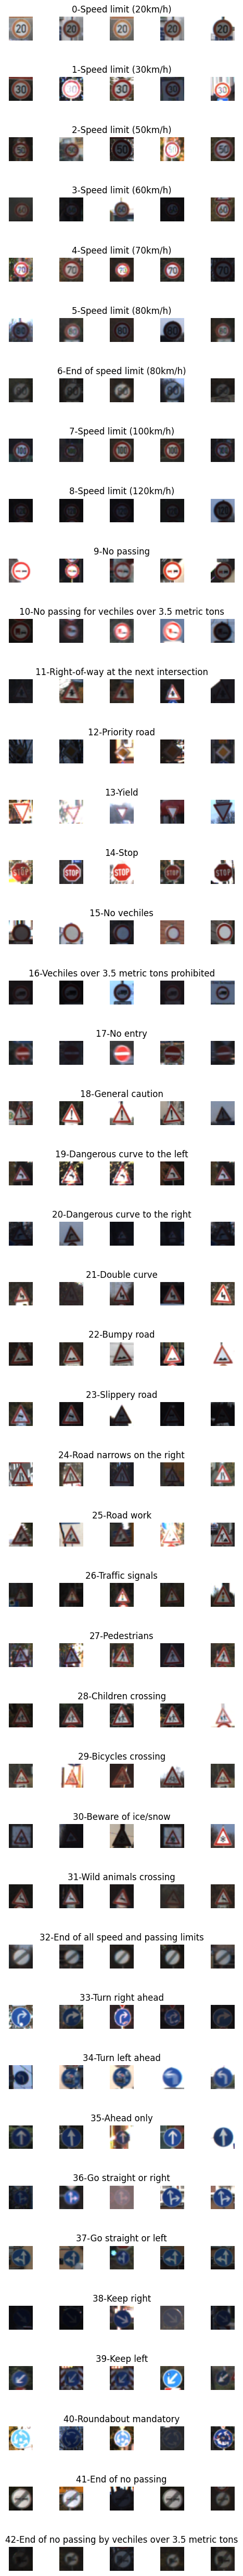

In [11]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

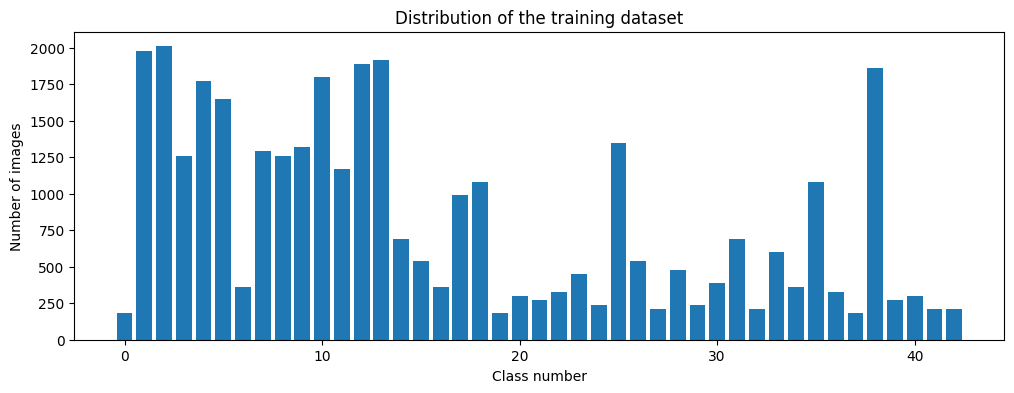

In [12]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [14]:
import cv2

(32, 32, 3)
36


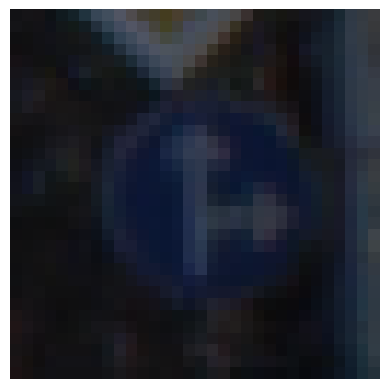

In [15]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print (y_train[1000])

In [16]:
#convert rgb image to gray image because colors are not important features ==> reduce depth ==> neural network
#with less parameters ==> neural network more efficient
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


(32, 32)


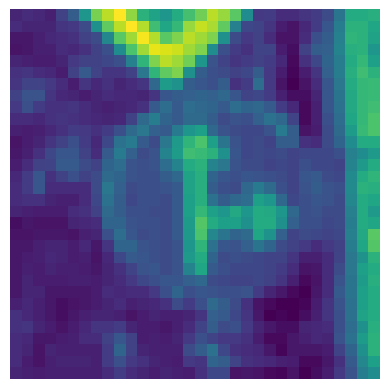

In [17]:
test = grayscale(X_train[1000])
plt.imshow(test)
plt.axis("off")
print(test.shape)

In [18]:
#histogram equalization: increase of constrat, defines better the features in the image
#equalizeHist only accept gray images (immages with depth 1)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


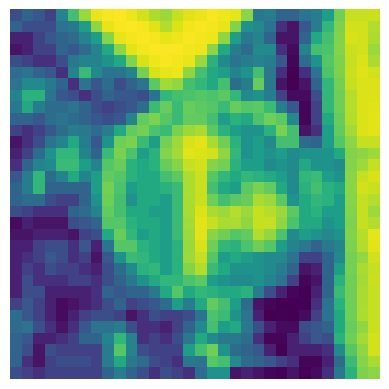

In [19]:
test = equalize(test)
plt.imshow(test)
plt.axis("off")
print(test.shape)

In [20]:
def preprocesing(img):
    img = grayscale(img)
    img = equalize(img)
    #normalization : all pixels between 0 and 1
    img = img/255
    return img

In [21]:
X_train = np.array(list(map(preprocesing, X_train)))
X_val = np.array(list(map(preprocesing, X_val)))
X_test = np.array(list(map(preprocesing,  X_test)))

(34799, 32, 32)


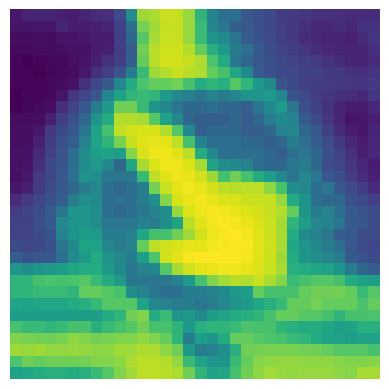

In [22]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [23]:
""" 
CNN : apply a filter to the channel of the image
(34799, 32, 32) ==> 1 channel is present
Add depth to the data
"""
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [24]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [25]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


(34799, 32, 32, 1)


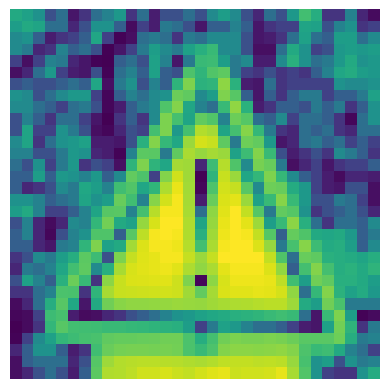

In [26]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [27]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [28]:
def leNet_model():
    model = Sequential()
    #convolutional 2D consist of filters that recognize features from the image
    #30 filters - (5, 5) size of the filter - (32, 32, 1) shape of the input image
    model.add(Conv2D(30, (5, 5) ,input_shape= (32, 32, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(15, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #reshape the output into 1D array of shape 540 = 6*6*15
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    #compile model
    model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [29]:
model = leNet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 500)               2

c:\Users\bouzi\anaconda3\envs\tf2.4\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
!nvidia-smi

Sun Oct 30 22:21:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P5    20W /  N/A |    839MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("No GPU device found")

No GPU device found


In [4]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [32]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 8s 88ms/step - loss: 2.7715 - accuracy: 0.2475 - val_loss: 1.4340 - val_accuracy: 0.5878
Epoch 2/10
87/87 [==============================] - 7s 83ms/step - loss: 1.1577 - accuracy: 0.6323 - val_loss: 0.8787 - val_accuracy: 0.7261
Epoch 3/10
87/87 [==============================] - 7s 86ms/step - loss: 0.8378 - accuracy: 0.7306 - val_loss: 0.7078 - val_accuracy: 0.7875
Epoch 4/10
87/87 [==============================] - 7s 85ms/step - loss: 0.7155 - accuracy: 0.7714 - val_loss: 0.6431 - val_accuracy: 0.8098
Epoch 5/10
87/87 [==============================] - 7s 84ms/step - loss: 0.6364 - accuracy: 0.7949 - val_loss: 0.6543 - val_accuracy: 0.8132
Epoch 6/10
87/87 [==============================] - 7s 85ms/step - loss: 0.5665 - accuracy: 0.8200 - val_loss: 0.5955 - val_accuracy: 0.8302
Epoch 7/10
87/87 [==============================] - 8s 91ms/step - loss: 0.5222 - accuracy: 0.8354 - val_loss: 0.5379 - val_accuracy: 0.8549
Epoch 8/10
87

Text(0.5, 0, 'epoch')

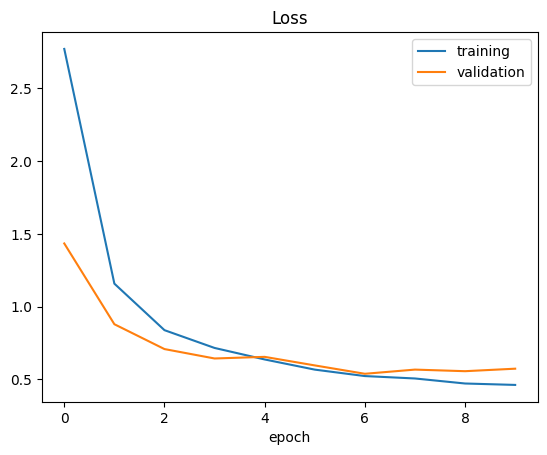

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

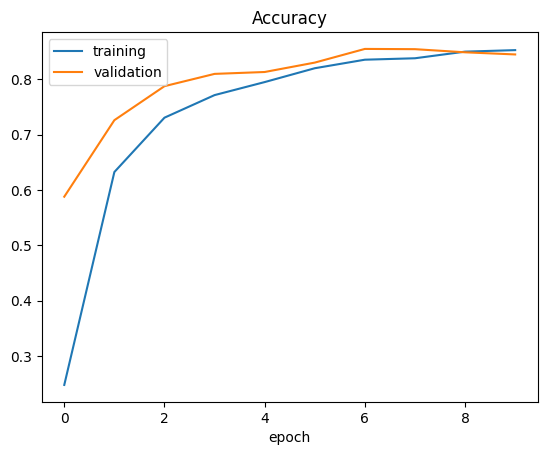

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [38]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.7354462146759033
Test Accuracy:  0.8200316429138184
